In [1]:
from sklearn.mixture import GaussianMixture
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from scipy.stats import bernoulli

from ResNet.Models import ResNet
from AutoEncoder.Models import AutoEncoder
from GenerativeClassifier import GenerativeClassifier as GC

import torch
import torch.nn as nn
from torch import distributions as D
from torch.distributions import MultivariateNormal as MVN

import torchvision as tv
from torchvision.transforms import transforms

import pickle
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


In [2]:
def get_mnist(batch_size):
  transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.30811,))
    ]
  )

  train_set = tv.datasets.MNIST(
    '../data/', train=True, download=True, transform=transform
  )
  test_set = tv.datasets.MNIST(
    '../data/', train=False, download=True, transform=transform
  )

  train_loader = torch.utils.data.DataLoader(
    train_set, batch_size
  )
  test_loader = torch.utils.data.DataLoader(
    test_set, batch_size
  )

  return train_loader, test_loader
train_loader, test_loader = get_mnist(2)

In [3]:
model = ResNet(1, 10).to(device)
model.load_state_dict(torch.load('chkpt/resnet_mnist.tar')['model_state_dict'])
model.eval()
with open('chkpt/encoded_mean_var_mnist_result.pickle', 'rb') as in_file:
  d = pickle.load(in_file)
  mean = d['mean'].to(device)
  var = d['var'].to(device)

enc = AutoEncoder(784, 20, 15).to(device)
enc.load_state_dict(torch.load('chkpt/encoder_mnist.tar')['model_state_dict'])
enc.eval();

gen_clf = GC(model, enc, 28*28, 10, mean, var)

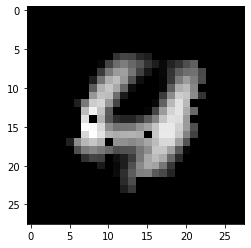

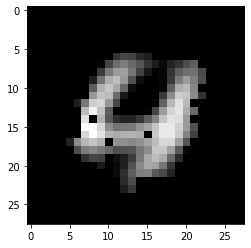

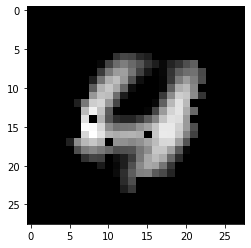

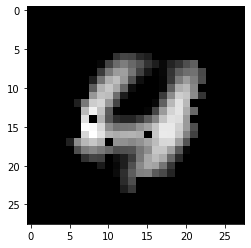

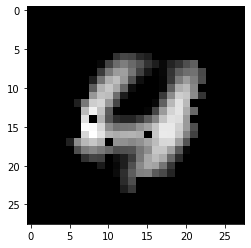

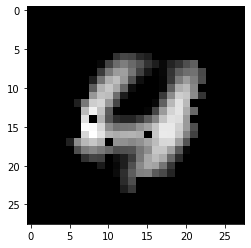

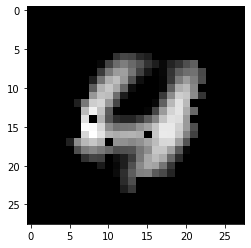

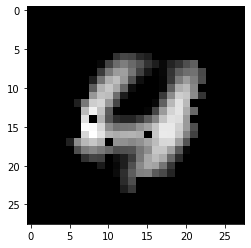

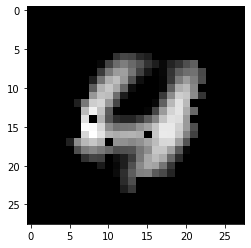

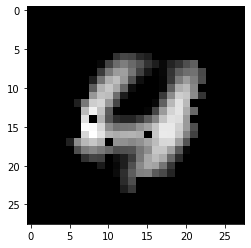

In [12]:
for i in range(10):
  plt.imshow(enc.decode(mean[i]).cpu().detach().numpy().reshape((28,28)), cmap='gray')
  plt.show()

tensor([-5.1006e+10, -7.5430e+10], device='cuda:0', grad_fn=<AddBackward0>)


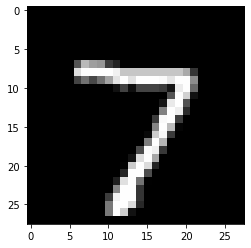

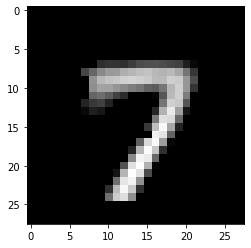

tensor([-1.7584e+14, -1.6588e+13], device='cuda:0', grad_fn=<AddBackward0>)


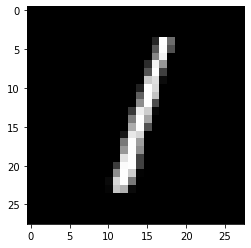

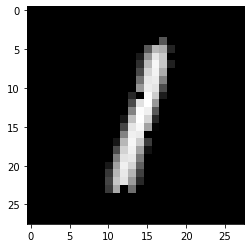

tensor([-6.7391e+10, -7.5689e+13], device='cuda:0', grad_fn=<AddBackward0>)


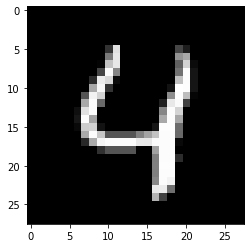

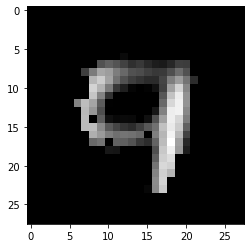

In [13]:
for i, (x,y) in enumerate(test_loader):
  x = x.to(device)
  y = y.to(device)
  print(gen_clf(x))
  # print()
  # print(gen_clf.pdf(x))
  plt.imshow(x[0].detach().cpu().numpy().reshape((28,28)), cmap='gray')
  plt.show()
  z = enc.encode(x.view((2,784)))
  xp = enc.decode(z)
  plt.imshow(xp[0].detach().cpu().numpy().reshape((28,28)), cmap='gray')
  plt.show()
  if i > 1:
    break


In [6]:
for x,y in test_loader:
  x = x.to(device)
  y = y.to(device)
  print(gen_clf(x))
  print()
  print(gen_clf.pdf(x))
  print()
  print()
  break

  

tensor([-5.1006e+10, -7.5430e+10], device='cuda:0', grad_fn=<AddBackward0>)

tensor([-1.7737e+20, -2.6181e+20], device='cuda:0', grad_fn=<AddBackward0>)




In [7]:
data = datasets.load_digits()
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

gmm = GaussianMixture(10, max_iter=500000)
gmm = gmm.fit(X_train)
# samples = gmm.sample(10)

# for i in range(10):
#   plt.imshow(samples[0][i].reshape((8,8)), cmap='gray')
#   plt.title(samples[1][i])
#   plt.show()

# for i in range(10):
#   digit = gmm.means_[i]
#   plt.imshow(digit.reshape((8,8)), cmap='gray')
#   plt.title(f'{i}')
#   plt.show()

In [39]:
latent_size = 20

def acceptance(x, y):
  a = gen_clf(gen_clf.enc.decode(x).view(1,1,28,28))
  b = gen_clf(gen_clf.enc.decode(y).view(1,1,28,28))
  p = a - b
  u = np.random.random()
  return p > np.log(u)


def nextState(x):
  K = 20
  y = np.random.multivariate_normal(x.view(20).detach().cpu().numpy(), np.eye(K))
  y = torch.Tensor(y).to(device).view(1,1,20)
  accept = acceptance(y, x)
  if accept:
    return y
  else:
    return x

def metropolis(x, n_samples=1000):
  logprobs = np.zeros(n_samples)
  x_samples = np.zeros((n_samples, 784))
  for i in range(n_samples):
    logprobs[i] = gen_clf(gen_clf.enc.decode(x).view(1,1,28,28))
    x = nextState(x)
    x_samples[i, :] = gen_clf.enc.decode(x).detach().cpu().view(28*28).numpy().copy()
  return x_samples, logprobs


In [40]:
initial = mean[0]
initial += torch.randn(20).to(device)
# plt.imshow(initial.detach().cpu().numpy().reshape(28,28), cmap='gray')
# plt.show()
samples, logprobs = metropolis(initial.view(1,1,20).to(device), 100)
# samples, logprobs = metropolis(mean[0].view(1,1,28,28).to(device), 100)
# samples, logprobs = metropolis(torch.randn(1,1,28,28).to(device), 100)

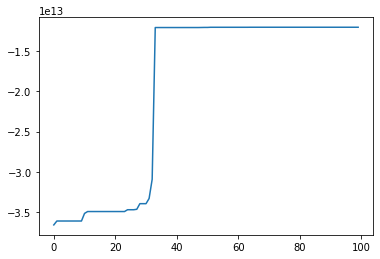

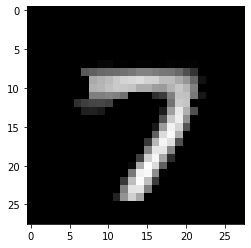

[-3.66153973e+13 -3.61290845e+13 -3.61290845e+13 -3.61290845e+13
 -3.61290845e+13 -3.61290845e+13 -3.61290845e+13 -3.61290845e+13
 -3.61290845e+13 -3.61290845e+13 -3.51840785e+13 -3.49492960e+13
 -3.49492960e+13 -3.49492960e+13 -3.49492960e+13 -3.49492960e+13
 -3.49492960e+13 -3.49492960e+13 -3.49492960e+13 -3.49492960e+13
 -3.49492960e+13 -3.49492960e+13 -3.49492960e+13 -3.49492960e+13
 -3.47245673e+13 -3.47245673e+13 -3.47245673e+13 -3.46677597e+13
 -3.39699072e+13 -3.39699072e+13 -3.39699072e+13 -3.33255446e+13
 -3.09333548e+13 -1.20357567e+13 -1.20345476e+13 -1.20345476e+13
 -1.20345476e+13 -1.20345476e+13 -1.20345476e+13 -1.20345476e+13
 -1.20345476e+13 -1.20345476e+13 -1.20344784e+13 -1.20335085e+13
 -1.20335085e+13 -1.20335085e+13 -1.20335085e+13 -1.20335085e+13
 -1.20272548e+13 -1.20194156e+13 -1.20194156e+13 -1.20016758e+13
 -1.20016758e+13 -1.20016758e+13 -1.20016758e+13 -1.20016758e+13
 -1.20016758e+13 -1.20016758e+13 -1.20016758e+13 -1.20016758e+13
 -1.20016758e+13 -1.20016

In [41]:
plt.plot(logprobs)
plt.show()

plt.imshow(samples[-1].reshape(28,28), cmap='gray')
plt.show()

print(logprobs)

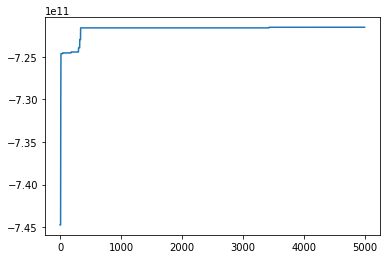

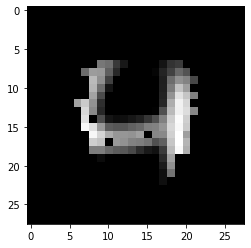

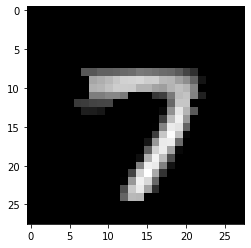

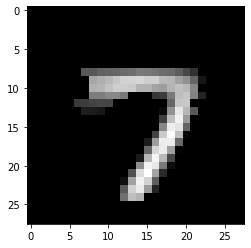

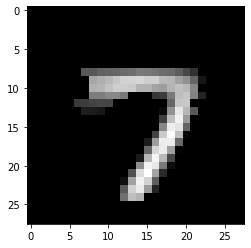

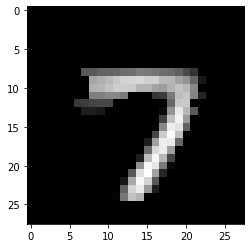

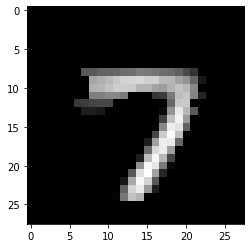

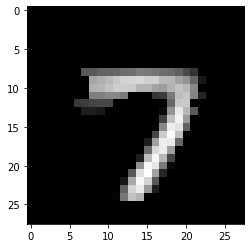

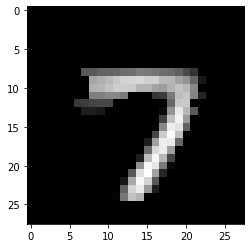

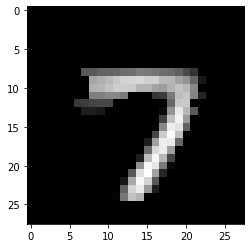

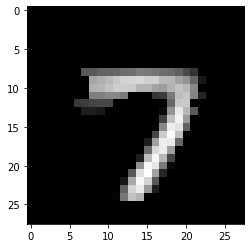

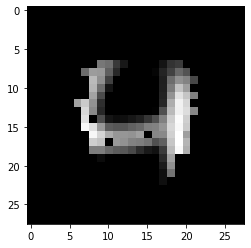

IndexError: index -5499 is out of bounds for axis 0 with size 5000

In [48]:
with open('bad_samples_logprobs.pickle','rb') as out:
  d = pickle.load(out)
  probs = d['logprobs']
  samples = d['samples']

plt.plot(probs)
plt.show()
for i in range(20):
  plt.imshow(samples[-500*i+1].reshape(28,28), cmap='gray')
  plt.show()